## Well Site Identification in Canadian Light Oil Production
Identifying high probability methane venting sites in Canada.

This notebook is the early stages of a greater project aimed at using satellite imagery, atmospheric composition, and machine learning to identify emissions sources in Canada. These  sources fall into two categories - known and unknown emissions. Further, each category can be subdivided further - quantifiable and non-quantifiable. The aim of this project is to leverage rapidly-advancing technology to enhance our understanding of the emissions we generate, and are all responsible for.

In this notebook, we will focus in on differentiating between two types of oil production sites - one with low methane emissions, another with high emissions.
1. Oil production tied-in to infrastructure (typically gas-conserving)
2. Oil production not tied-in to infrastructure (typically gas-venting)

In doing so, it allows us to evaluate whether oil production sites that are not tied-in to infrastructure are causing high methane content in the atmosphere, as detected by the Sentinel 5P satellite.
    

### 1. Project Setup

This project will employ the fastai library to train our model.

In [22]:
#automatically reload any edits to libraries
%reload_ext autoreload
%autoreload 2

#display all charts directly in notebook
%matplotlib inline

In [23]:
#import fastai package
from fastai.vision import *
from fastai.metrics import error_rate

### 2. Create the Dataset

Satellite imagery will be used to train our model.

Steps to build labeled dataset.
1. Use satellite imagery to find oil production sites of both types.
2. Screenshot the satellite imagery.
3. Label resulting screenshots.
4. Feed into model.

### 3. Import the Dataset

**Random Notes**
- it pays to think creatively - generate picture from things that aren't pictures
- example: mouse movement/clicks for fraud detection, turning a sound into an image

**Understand the Data**
1. how the directories are structured
2. how the images are labeled - this often changes between datasets
3. what sample images look like

**Use doc() Function!**
- can go on their github and download Notebooks of all fastai_docs - useful for how to get images / labels

**Souring Data from Different Spots**
- from_folder (imageNet style dataset)
- from_csv (list of file name and label in a csv file)
- using from_name_re (regex expression directly out of file name)

In [4]:
#bring up documentation for the function from_name.re
doc(ImageDataBunch.from_folder)

In [24]:
#initialize parameters to feed into ImageDataBunch object

#define batch size - how many images  you train on at once
bs = 16

#define folder path
path = '/home/jupyter/tinyleak/wellsite_data'

tfms = get_transforms(do_flip=False)

In [25]:
#build image-net style dataset (folder structure)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224)

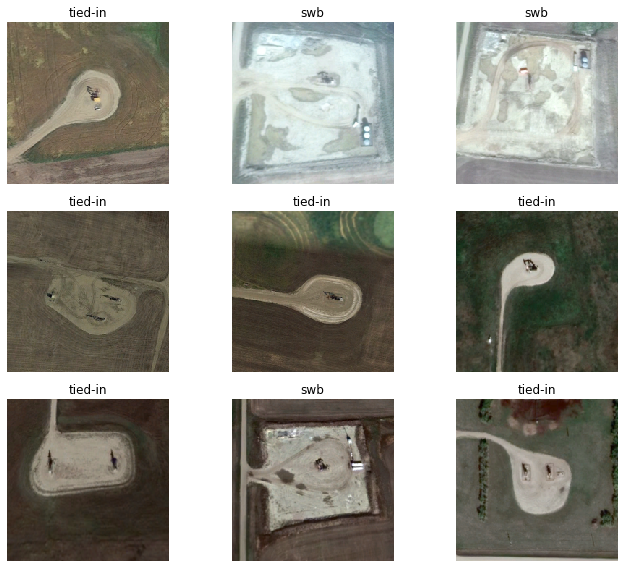

In [26]:
#visualize the dataset
data.show_batch(rows=3, figsize=(10,8))

In [27]:
#print out the labels
print(data.classes)

['mwb', 'swb', 'tied-in']


### 4. Train the Model (resnet34 - part 1 of 2)

In [28]:
#define *learn* object (data + model), in this case a neural network learner 
#using transfer learning technique from pre-defined resnet34 weightings
tinyleak = cnn_learner(data, models.resnet34, metrics=error_rate)

In [29]:
#train model for 4 epochs (cycle through data 4 times)
#runs fairly fast because we're only training the last few layers of the neural net
#this is part 1 of 2 in the training cycle, we will improve the model in Section 5
tinyleak.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.127072,4.997099,0.851852,00:02
1,2.032664,2.896119,0.814815,00:02
2,1.775067,1.435636,0.518519,00:02
3,1.575493,1.093574,0.407407,00:02


In [30]:
#saved results of first trained dataset
tinyleak.save('model-v1')

### 5. Evaluate Model Results

In [31]:
#define *interpretation* object by passing *learn* object in order to better understand the model
tinyleak_int = ClassificationInterpretation.from_learner(tinyleak)

#define loss object that shows the things we were most confident about, but got wrong 
losses,idxs = tinyleak_int.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

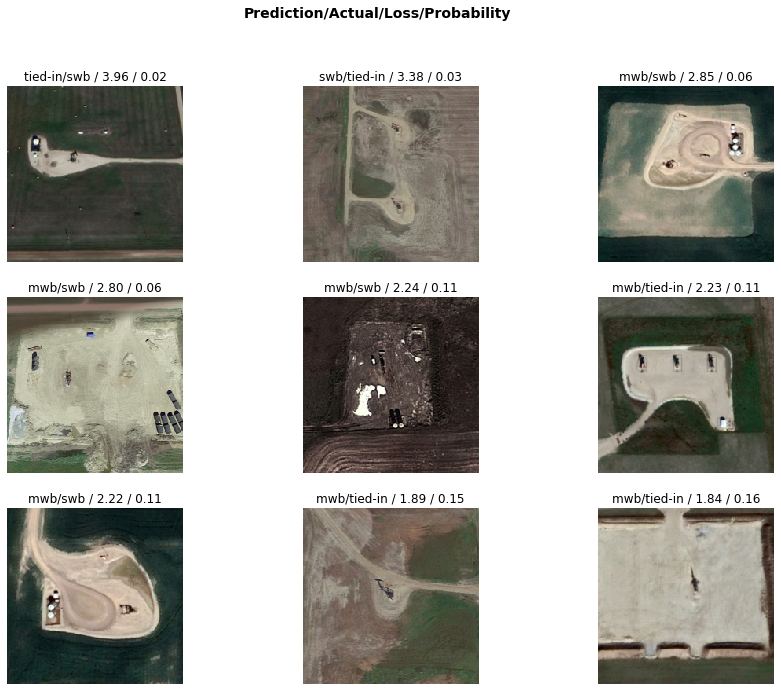

In [32]:
#plot the biggest mistakes of the model
tinyleak_int.plot_top_losses(9, figsize=(15,11))

In [20]:
#let's understand the plot_top_losses function a little bit better
doc(tinyleak_int.plot_top_losses)

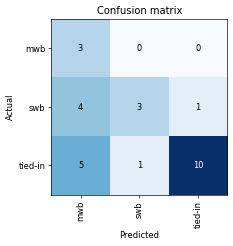

In [33]:
#summarize the classification results in a confusion matrix
tinyleak_int.plot_confusion_matrix(figsize=(4,4), dpi=60)

In [34]:
#take the top wrongly classified items out of the confusion matrix
tinyleak_int.most_confused(min_val=1)

[('tied-in', 'mwb', 5),
 ('swb', 'mwb', 4),
 ('swb', 'tied-in', 1),
 ('tied-in', 'swb', 1)]

### 6. Improve the Model (2 of 2)

In [35]:
#initiate part 2 of 2 of the training
#nfreeze allows us to train the entire model, not the last few layers
tinyleak.unfreeze()

In [36]:
#with the model unfrozen, we can try to train it again
tinyleak.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.721953,1.060231,0.407407,00:02
1,0.830619,3.037226,0.777778,00:02
2,0.739059,3.738658,0.777778,00:02
3,0.636102,3.661231,0.777778,00:02


In [37]:
#the model definitely got worse! 41% error rate vs. a final 78% error
#let's reload the existing model
tinyleak.load('model-v1')

Learner(data=ImageDataBunch;

Train: LabelList (75 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
swb,swb,swb,swb,swb
Path: /home/jupyter/tinyleak/wellsite_data;

Valid: LabelList (27 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
swb,swb,swb,swb,swb
Path: /home/jupyter/tinyleak/wellsite_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=

In [38]:
#find the optimal learning rate - how quickly we can teach it without blowing it up
tinyleak.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


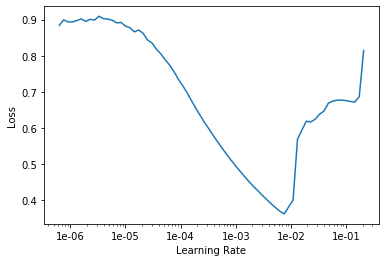

In [39]:
#plot learning rate - how quickly are we updating the parameters in the model (loss vs. learning rate)
tinyleak.recorder.plot()

In [54]:
#plot shows that the fastest we can teach the model with minimum loss is around 4e-2
#pass range of learning rates to model
tinyleak.load('model-v1')
tinyleak.unfreeze()
tinyleak.fit_one_cycle(8, max_lr=slice(5e-4,8e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.771658,1.075120,0.407407,00:02
1,0.816652,1.648493,0.629630,00:02
2,0.692288,1.808488,0.629630,00:02
3,0.607299,1.700513,0.518519,00:02
4,0.553614,1.492591,0.370370,00:02
5,0.489610,1.235700,0.407407,00:02
6,0.441317,1.172265,0.370370,00:02
7,0.389052,1.174300,0.370370,00:02


In [55]:
tinyleak.save('model-v2')

Based on the learning rate plot above, the learning rate should be around 2e-2
After trial and error, the small the learning rate the better the result.
Overall, adjusting the learning rate did not help me improve the accuracy of this model.

**Model Accuracy (resnet34):** 63%

### 7. Train the Model Again (using resnet50)

Changes:
- Train using resnet50
- Increase size of images for more detail
- Can reduce batch_size to preserve GPU memory (train less images at once)

In [58]:
#build image-net style dataset (folder structure)
data_v50 = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=299)

In [59]:
#define learning object
tinyleak_v50 = cnn_learner(data_v50, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


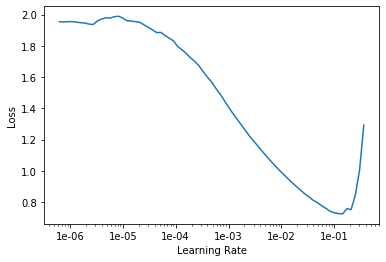

In [60]:
tinyleak_v50.lr_find()
tinyleak_v50.recorder.plot()

In [61]:
#train the model using resnet50
tinyleak_v50.fit_one_cycle(8, max_lr=slice(8e-4,2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.082262,1.072149,0.518519,00:05
1,1.962825,1.454247,0.666667,00:03
2,1.618598,1.757578,0.666667,00:03
3,1.370683,0.976226,0.444444,00:03
4,1.184551,0.890721,0.407407,00:03
5,1.032645,0.884683,0.333333,00:03
6,0.924424,0.962834,0.296296,00:03
7,0.849021,0.919456,0.259259,00:03


In [62]:
#let's save our results - hey that's better than before. Nice.
tinyleak_v50.save('tinyleak_v50')

Call it a day - first image classifier sucessfully classifying oil production sites based on leak potential with a 74% accuracy . Not bad for a small dataset built on screenshots from GoogleEarth!

~Jordan